In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit

In [62]:
sns.set()
%matplotlib inline

In [63]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
%autoreload 2

In [65]:
from sir_models.seir import SEIR

# Load data

In [66]:
df = pd.read_csv('data/data.csv', sep=';')

In [67]:
df.columns = ['date', 'region', 'total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day']
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

df['infected'] = df['total_infected'] - df['total_recovered'] - df['total_dead']

In [68]:
df = df[df.region == 'Москва'].reset_index()
#df = df.groupby('date').sum().reset_index()

In [69]:
df.head()

,index,date,region,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected
0,40,2020-03-12,Москва,21,0,0,0,21,0,21
1,122,2020-03-13,Москва,26,0,0,0,5,0,26
2,204,2020-03-14,Москва,35,0,0,0,9,0,35
3,286,2020-03-15,Москва,35,1,0,0,0,1,34
4,368,2020-03-16,Москва,53,1,0,0,18,0,52


In [70]:
print('First death')


First death


In [71]:
df = df[df.date >= df[df['total_dead'] > 0].iloc[0].date]
df.head()

,index,date,region,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected
13,1129,2020-03-25,Москва,410,14,2,2,120,5,394
14,1214,2020-03-26,Москва,546,15,2,0,136,1,529
15,1299,2020-03-27,Москва,703,18,3,1,157,3,682
16,1384,2020-03-28,Москва,817,18,5,2,114,0,794
17,1469,2020-03-29,Москва,1014,28,6,1,197,10,980


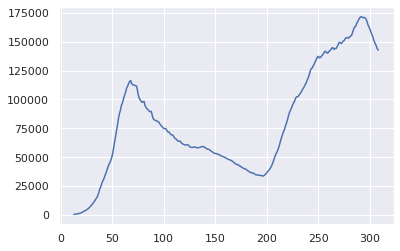

In [72]:
df['infected'].plot()

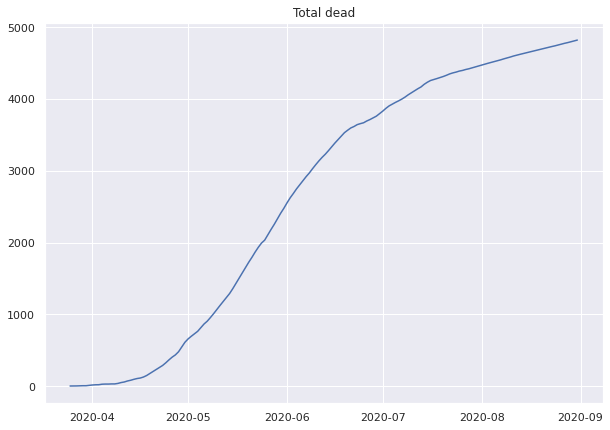

In [73]:
subset = df[(df.date >= '2020-03-01') & (df.date <= '2020-08-31')]
plt.figure(figsize=(10, 7))
plt.plot(subset.date, subset.total_dead)
plt.title("Total dead")
plt.show()

In [74]:
df[df['total_dead'] > 0].iloc[0]

index                               1129
date                 2020-03-25 00:00:00
region                            Москва
total_infected                       410
total_recovered                       14
total_dead                             2
deaths_per_day                         2
infected_per_day                     120
recovered_per_day                      5
infected                             394
Name: 13, dtype: object

# Smooth

In [75]:
df_smoothed = df.drop(columns=['region']).rolling(7).mean()
df_smoothed['date'] = df['date']
df_smoothed.head(10)

,index,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,date
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-25
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-26
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-27
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-28
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-29
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-30
19,1384.0,904.142857,27.285714,5.000000,1.571429,189.000000,8.714286,871.857143,2020-03-31
20,1469.0,1114.142857,41.714286,7.000000,2.000000,210.000000,14.428571,1065.428571,2020-04-01
21,1554.0,1389.714286,59.571429,9.428571,2.428571,275.571429,17.857143,1320.714286,2020-04-02
22,1639.0,1706.857143,81.000000,11.857143,2.428571,317.142857,21.428571,1614.000000,2020-04-03


Text(0.5, 1.0, 'Active infected')

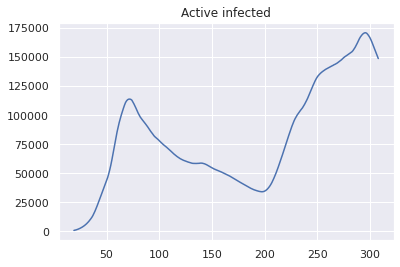

In [76]:
df_smoothed.infected.plot()
plt.title('Active infected')

Text(0.5, 1.0, 'Total infected')

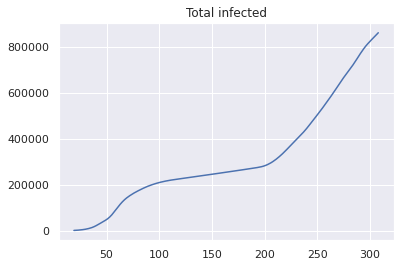

In [77]:
df_smoothed.total_infected.plot()
plt.title('Total infected')

Text(0.5, 1.0, 'Total dead')

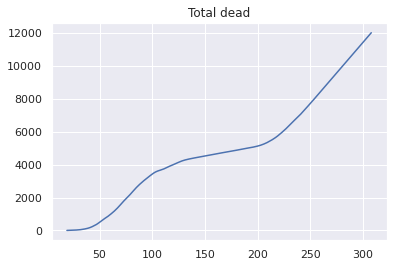

In [78]:
df_smoothed.total_dead.plot()
plt.title('Total dead')

In [79]:
# df = df_smoothed.dropna().reset_index(drop=True)

### Modelling infection fear and quarantine measures

[]

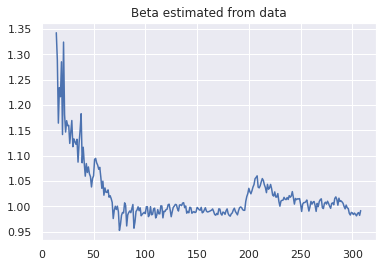

In [80]:
beta_from_data = df['infected'] / df['infected'].shift(1)
beta_from_data.plot()
plt.title('Beta estimated from data')
plt.plot()

In [81]:
beta_base = beta_from_data.max()
beta_base

1.3426395939086295

Text(0.5, 1.0, 'Infection "fear"')

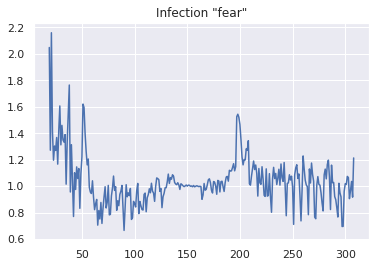

In [82]:
fear = df['infected_per_day']/df['infected_per_day'].rolling(7).mean()
plt.plot(fear)
plt.title('Infection "fear"')

[]

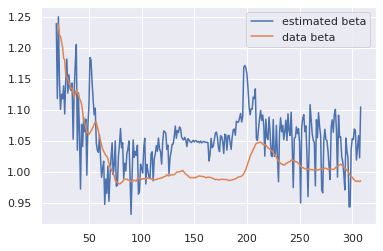

In [83]:
beta_fear = beta_base - 0.8 * 1/np.exp(fear)
plt.plot(beta_fear, label='estimated beta')
beta_from_data.rolling(7).mean().plot(label='data beta')
plt.legend()
plt.plot()

In [84]:
beta_fear

13          NaN
14          NaN
15          NaN
16          NaN
17          NaN
         ...   
304    1.019194
305    1.038356
306    1.058634
307    1.022832
308    1.104834
Name: infected_per_day, Length: 296, dtype: float64

In [85]:
beta_fear[50], beta_from_data[50]

(1.1068642003957876, 1.0600712603921405)

# Set global params

# SEIR full

In [273]:
model = SEIR(population)
subset = df
model.fit(subset)

S, E, I, R, D = model.predict_train()

result = model.fit_result_
result

In [286]:
subset.iloc[0]

index                               1129
date                 2020-03-25 00:00:00
region                            Москва
total_infected                       410
total_recovered                       14
total_dead                             2
deaths_per_day                         2
infected_per_day                     120
recovered_per_day                      5
infected                             394
Name: 13, dtype: object

In [287]:
S[0], I[0], R[0], D[0]

(9831094.57419568, 349.70334028980403, 471.51870180467364, 2.1607272485957547)

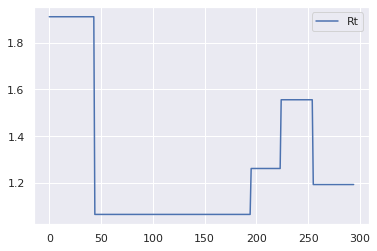

In [288]:
r0 = model.params['r0']
gamma = model.params['gamma']
q_coefs = {}
for key, value in model.params.items():
    if key.startswith('t'):
        t = int(key.split('_')[0][1:])
        q_coefs[t] = value.value
        
def stepwise(t, coefficients):
    base = min(list(coefficients.keys()))
    last_index = max(list(coefficients.keys()))
    index = min(max(base, int(base * round(float(t)/base))), last_index)
    return coefficients[index]

rt_vals = []
for t in range(1, len(df)):
    rt_vals.append(stepwise(t, q_coefs) * r0)
    
plt.figure()
plt.plot(rt_vals, label='Rt')
plt.legend()
plt.show()

In [289]:
r0, q_coefs

(<Parameter 'r0', value=3.55 (fixed), bounds=[-inf:inf]>,
 {30: 0.5383926313846698,
  60: 0.30000000009319117,
  90: 0.30000000170226215,
  120: 0.30000022319788366,
  150: 0.3000000020564637,
  180: 0.3000010471531273,
  210: 0.3553872437717206,
  240: 0.438284704412114,
  270: 0.3360305842783885})

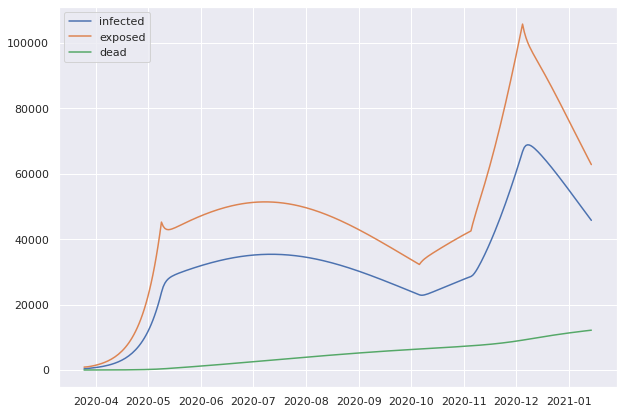

In [290]:
plt.figure(figsize=(10, 7))
plt.plot(subset.date, I, label='infected')
plt.plot(subset.date, E, label='exposed')
#plt.plot(subset.date, R, label='recovered')
plt.plot(subset.date, D, label='dead')
plt.legend()
plt.show()

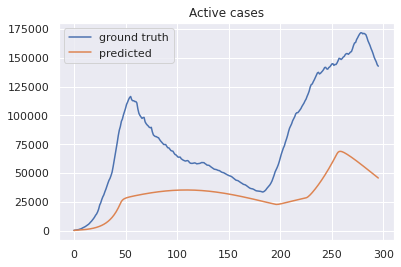

In [291]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

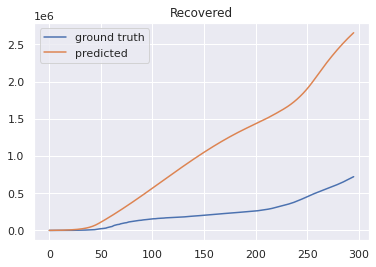

In [292]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

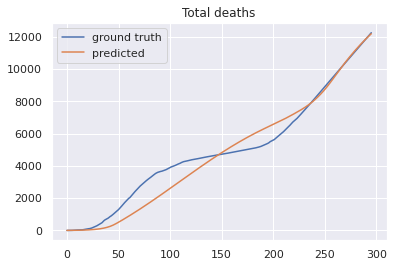

In [293]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

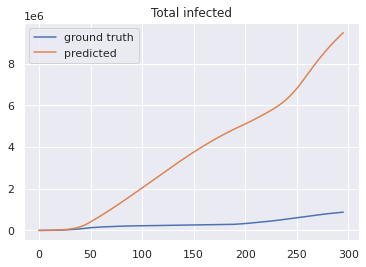

In [294]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_infected'], label='ground truth')
plt.plot(x, I.cumsum(), label='predicted')
plt.legend()
plt.title('Total infected')
plt.show()